# NB02: Gene Specificity Classification

For each of the 12,838 metal-important genes, compute fitness across all non-metal experiments
and classify as metal-specific, metal+stress, or general sick.

Uses both absolute and rate-based thresholds with sensitivity analysis.

**Pitfalls addressed**:
- Rate-based thresholds to handle variable experiment counts per organism (2-608 non-metal)
- Essential genes (~14%, ~82% core) are invisible in fitness data — noted as caveat
- Cross-validates against counter_ion_effects NaCl overlap results

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

PROJ = os.path.abspath('..')
MAIN_REPO = '/home/psdehal/pangenome_science/BERIL-research-observatory'
METAL_ATLAS = os.path.join(MAIN_REPO, 'projects', 'metal_fitness_atlas', 'data')
FITNESS_MOD = os.path.join(MAIN_REPO, 'projects', 'fitness_modules', 'data')
DATA_OUT = os.path.join(PROJ, 'data')
FIG_OUT = os.path.join(PROJ, 'figures')

## Load inputs

In [2]:
# Experiment classification from NB01
exp_class = pd.read_csv(os.path.join(DATA_OUT, 'experiment_classification.csv'))
print(f'Experiments classified: {len(exp_class)}')

# Metal-important genes from atlas
metal_genes = pd.read_csv(os.path.join(METAL_ATLAS, 'metal_important_genes.csv'))
print(f'Metal-important gene records: {len(metal_genes)}')
print(f'Unique genes (org+locus): {metal_genes.groupby(["orgId","locusId"]).ngroups}')

# Get unique metal-important genes per organism
metal_gene_set = defaultdict(set)
for _, row in metal_genes.iterrows():
    metal_gene_set[row['orgId']].add(row['locusId'])

for org in sorted(metal_gene_set)[:5]:
    print(f'  {org}: {len(metal_gene_set[org])} metal-important genes')

Experiments classified: 6504
Metal-important gene records: 12838
Unique genes (org+locus): 7609
  BFirm: 175 metal-important genes
  Btheta: 276 metal-important genes
  Caulo: 481 metal-important genes
  Cola: 217 metal-important genes
  Cup4G11: 544 metal-important genes


## Compute gene fitness across non-metal experiments

In [3]:
STRESS_CATEGORIES = {'antibiotic', 'osmotic', 'oxidative', 'pH', 'temperature', 
                     'dna_damage', 'detergent_solvent', 'other_stress'}

def compute_gene_specificity(org, metal_loci, exp_class_df, fitness_mod_path):
    """For an organism, compute specificity metrics for each metal-important gene."""
    fit_file = os.path.join(fitness_mod_path, 'matrices', f'{org}_fitness_matrix.csv')
    t_file = os.path.join(fitness_mod_path, 'matrices', f'{org}_t_matrix.csv')
    
    if not os.path.exists(fit_file) or not os.path.exists(t_file):
        return None
    
    fit_mat = pd.read_csv(fit_file, index_col=0)
    t_mat = pd.read_csv(t_file, index_col=0)
    
    # Get non-metal experiments for this organism
    org_exps = exp_class_df[exp_class_df.orgId == org]
    non_metal_exps = org_exps[org_exps.stress_category != 'metal']
    non_metal_stress_exps = org_exps[org_exps.stress_category.isin(STRESS_CATEGORIES)]
    
    # Filter to experiments that exist in the fitness matrix
    available_exps = set(fit_mat.columns)
    nm_exps = [e for e in non_metal_exps['expName'] if e in available_exps]
    nm_stress_exps = [e for e in non_metal_stress_exps['expName'] if e in available_exps]
    
    if not nm_exps:
        return None
    
    # Get non-metal experiment categories for category counting
    exp_to_cat = dict(zip(org_exps['expName'], org_exps['stress_category']))
    
    results = []
    for locus in metal_loci:
        if locus not in fit_mat.index:
            continue
        
        # Get fitness and t-scores across non-metal experiments
        nm_fit = fit_mat.loc[locus, nm_exps].astype(float)
        nm_t = t_mat.loc[locus, nm_exps].astype(float)
        
        # Count sick experiments (fit < -1 AND |t| > 4)
        sick_mask = (nm_fit < -1) & (nm_t.abs() > 4)
        n_sick_nonmetal = sick_mask.sum()
        n_total_nonmetal = len(nm_exps)
        sick_rate = n_sick_nonmetal / n_total_nonmetal if n_total_nonmetal > 0 else 0
        
        # Sick in stress experiments specifically
        if nm_stress_exps:
            stress_fit = fit_mat.loc[locus, [e for e in nm_stress_exps if e in fit_mat.columns]].astype(float)
            stress_t = t_mat.loc[locus, [e for e in nm_stress_exps if e in t_mat.columns]].astype(float)
            n_sick_stress = ((stress_fit < -1) & (stress_t.abs() > 4)).sum()
            n_total_stress = len(nm_stress_exps)
            stress_sick_rate = n_sick_stress / n_total_stress if n_total_stress > 0 else 0
        else:
            n_sick_stress = 0
            n_total_stress = 0
            stress_sick_rate = 0
        
        # Count distinct non-metal categories where gene is sick
        sick_exps = nm_fit.index[sick_mask]
        sick_categories = set(exp_to_cat.get(e, 'other') for e in sick_exps)
        n_sick_categories = len(sick_categories)
        
        # Mean fitness across non-metal experiments
        mean_nm_fit = nm_fit.mean()
        min_nm_fit = nm_fit.min()
        
        results.append({
            'orgId': org,
            'locusId': locus,
            'n_nonmetal_exps': n_total_nonmetal,
            'n_sick_nonmetal': n_sick_nonmetal,
            'sick_rate_nonmetal': sick_rate,
            'n_stress_exps': n_total_stress,
            'n_sick_stress': n_sick_stress,
            'stress_sick_rate': stress_sick_rate,
            'n_sick_categories': n_sick_categories,
            'sick_categories': ','.join(sorted(sick_categories)) if sick_categories else '',
            'mean_nonmetal_fit': mean_nm_fit,
            'min_nonmetal_fit': min_nm_fit,
        })
    
    return pd.DataFrame(results)

print('Specificity computation function defined')

Specificity computation function defined


In [4]:
# Process all organisms
all_specificity = []
for org in sorted(metal_gene_set.keys()):
    loci = metal_gene_set[org]
    result = compute_gene_specificity(org, loci, exp_class, FITNESS_MOD)
    if result is not None and len(result) > 0:
        all_specificity.append(result)
        print(f'  {org}: {len(result)} genes processed, '
              f'{result["n_nonmetal_exps"].iloc[0]} non-metal exps, '
              f'median sick_rate={result["sick_rate_nonmetal"].median():.3f}')
    else:
        print(f'  {org}: SKIPPED (no fitness matrix or no non-metal experiments)')

spec_df = pd.concat(all_specificity, ignore_index=True)
print(f'\nTotal gene-specificity records: {len(spec_df)}')
print(f'Organisms: {spec_df["orgId"].nunique()}')

  BFirm: 175 genes processed, 109 non-metal exps, median sick_rate=0.009


  Btheta: SKIPPED (no fitness matrix or no non-metal experiments)


  Caulo: 481 genes processed, 182 non-metal exps, median sick_rate=0.104


  Cola: 217 genes processed, 182 non-metal exps, median sick_rate=0.033


  Cup4G11: 544 genes processed, 95 non-metal exps, median sick_rate=0.000


  DvH: SKIPPED (no fitness matrix or no non-metal experiments)


  Kang: 223 genes processed, 100 non-metal exps, median sick_rate=0.120


  Korea: 151 genes processed, 154 non-metal exps, median sick_rate=0.110


  Koxy: 338 genes processed, 200 non-metal exps, median sick_rate=0.000


  Marino: 308 genes processed, 231 non-metal exps, median sick_rate=0.013


  Methanococcus_JJ: 395 genes processed, 111 non-metal exps, median sick_rate=0.342


  Methanococcus_S2: 255 genes processed, 353 non-metal exps, median sick_rate=0.357


  Pedo557: 426 genes processed, 159 non-metal exps, median sick_rate=0.044


  Phaeo: 185 genes processed, 255 non-metal exps, median sick_rate=0.051


  Ponti: 432 genes processed, 90 non-metal exps, median sick_rate=0.056


  SynE: 425 genes processed, 120 non-metal exps, median sick_rate=0.275


  WCS417: 93 genes processed, 197 non-metal exps, median sick_rate=0.005


  acidovorax_3H11: 323 genes processed, 124 non-metal exps, median sick_rate=0.016


  psRCH2: 460 genes processed, 289 non-metal exps, median sick_rate=0.022


  pseudo13_GW456_L13: 193 genes processed, 100 non-metal exps, median sick_rate=0.030


  pseudo1_N1B4: 202 genes processed, 141 non-metal exps, median sick_rate=0.000


  pseudo3_N2E3: 306 genes processed, 201 non-metal exps, median sick_rate=0.045


  pseudo5_N2C3_1: 417 genes processed, 176 non-metal exps, median sick_rate=0.017


  pseudo6_N2E2: 289 genes processed, 181 non-metal exps, median sick_rate=0.017

Total gene-specificity records: 6838
Organisms: 22


## Classify genes using rate-based thresholds

In [5]:
def classify_specificity(row, threshold=0.05):
    """Classify gene specificity using rate-based threshold."""
    if row['sick_rate_nonmetal'] < threshold:
        return 'metal_specific'
    elif row['stress_sick_rate'] >= threshold and row['n_sick_categories'] < 3:
        return 'metal_plus_stress'
    elif row['n_sick_categories'] >= 3:
        return 'general_sick'
    else:
        return 'metal_plus_stress'  # sick in non-stress conditions

# Primary classification at 5% threshold
spec_df['specificity_5pct'] = spec_df.apply(lambda r: classify_specificity(r, 0.05), axis=1)

# Summary
cat_counts = spec_df['specificity_5pct'].value_counts()
print('Gene specificity classification (5% threshold):')
for cat, count in cat_counts.items():
    print(f'  {cat:20s}: {count:6d} ({100*count/len(spec_df):.1f}%)')

Gene specificity classification (5% threshold):
  metal_specific      :   3691 (54.0%)
  general_sick        :   2621 (38.3%)
  metal_plus_stress   :    526 (7.7%)


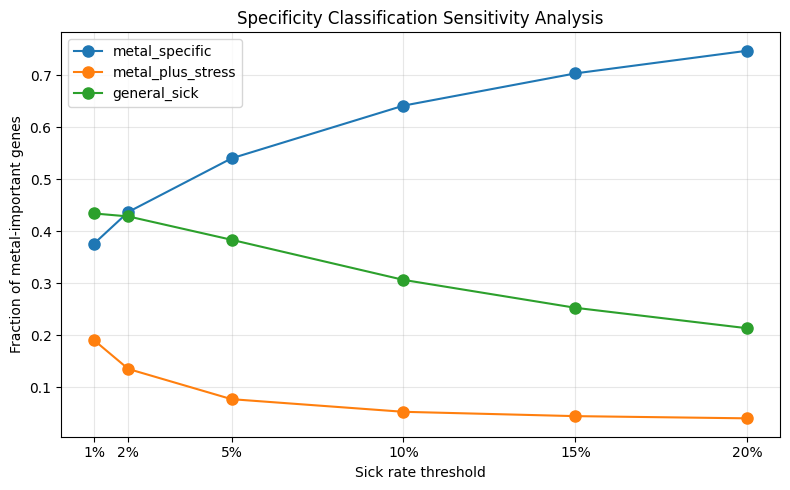

Saved: figures/threshold_sensitivity.png


In [6]:
# Sensitivity analysis: vary threshold
thresholds = [0.01, 0.02, 0.05, 0.10, 0.15, 0.20]
sensitivity = []
for thresh in thresholds:
    col = f'specificity_{int(thresh*100)}pct'
    spec_df[col] = spec_df.apply(lambda r: classify_specificity(r, thresh), axis=1)
    counts = spec_df[col].value_counts()
    for cat in ['metal_specific', 'metal_plus_stress', 'general_sick']:
        sensitivity.append({
            'threshold': thresh,
            'category': cat,
            'count': counts.get(cat, 0),
            'fraction': counts.get(cat, 0) / len(spec_df)
        })

sens_df = pd.DataFrame(sensitivity)

# Plot sensitivity
fig, ax = plt.subplots(figsize=(8, 5))
for cat in ['metal_specific', 'metal_plus_stress', 'general_sick']:
    subset = sens_df[sens_df.category == cat]
    ax.plot(subset['threshold'], subset['fraction'], 'o-', label=cat, markersize=8)
ax.set_xlabel('Sick rate threshold')
ax.set_ylabel('Fraction of metal-important genes')
ax.set_title('Specificity Classification Sensitivity Analysis')
ax.legend()
ax.set_xticks(thresholds)
ax.set_xticklabels([f'{t:.0%}' for t in thresholds])
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(FIG_OUT, 'threshold_sensitivity.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/threshold_sensitivity.png')

In [7]:
# Per-organism breakdown at 5% threshold
org_spec = spec_df.groupby(['orgId', 'specificity_5pct']).size().unstack(fill_value=0)
org_spec['total'] = org_spec.sum(axis=1)
if 'metal_specific' in org_spec.columns:
    org_spec['pct_metal_specific'] = 100 * org_spec['metal_specific'] / org_spec['total']
    org_spec = org_spec.sort_values('pct_metal_specific', ascending=False)
    print('Per-organism specificity breakdown (5% threshold):')
    display_cols = [c for c in ['metal_specific', 'metal_plus_stress', 'general_sick', 'total', 'pct_metal_specific'] if c in org_spec.columns]
    print(org_spec[display_cols].to_string())
else:
    print('No metal-specific genes found at 5% threshold')
    print(org_spec.to_string())

Per-organism specificity breakdown (5% threshold):
specificity_5pct    metal_specific  metal_plus_stress  general_sick  total  pct_metal_specific
orgId                                                                                         
pseudo1_N1B4                   162                  2            38    202           80.198020
Koxy                           269                 13            56    338           79.585799
Cup4G11                        426                 14           104    544           78.308824
Marino                         224                  7            77    308           72.727273
pseudo6_N2E2                   192                  2            95    289           66.435986
acidovorax_3H11                211                  9           103    323           65.325077
pseudo5_N2C3_1                 272                  9           136    417           65.227818
psRCH2                         287                  1           172    460           62.391304

## Cross-validation against counter_ion_effects

In [8]:
# The counter_ion_effects project found 39.8% overlap between metal and NaCl genes
# Our general_sick + metal_plus_stress categories should capture a similar fraction

# Check: what fraction of metal-important genes are sick under osmotic stress specifically?
osmotic_sick = spec_df[spec_df['sick_categories'].str.contains('osmotic', na=False)]
pct_osmotic = 100 * len(osmotic_sick) / len(spec_df)
print(f'Metal-important genes also sick under osmotic stress: {len(osmotic_sick)} ({pct_osmotic:.1f}%)')
print(f'Counter_ion_effects found: 39.8% overlap with NaCl')
print(f'Difference likely due to: our stricter threshold (fit<-1 AND |t|>4 vs just fit<-1),'
      f' and osmotic category includes non-NaCl osmotic stresses')

Metal-important genes also sick under osmotic stress: 1008 (14.7%)
Counter_ion_effects found: 39.8% overlap with NaCl
Difference likely due to: our stricter threshold (fit<-1 AND |t|>4 vs just fit<-1), and osmotic category includes non-NaCl osmotic stresses


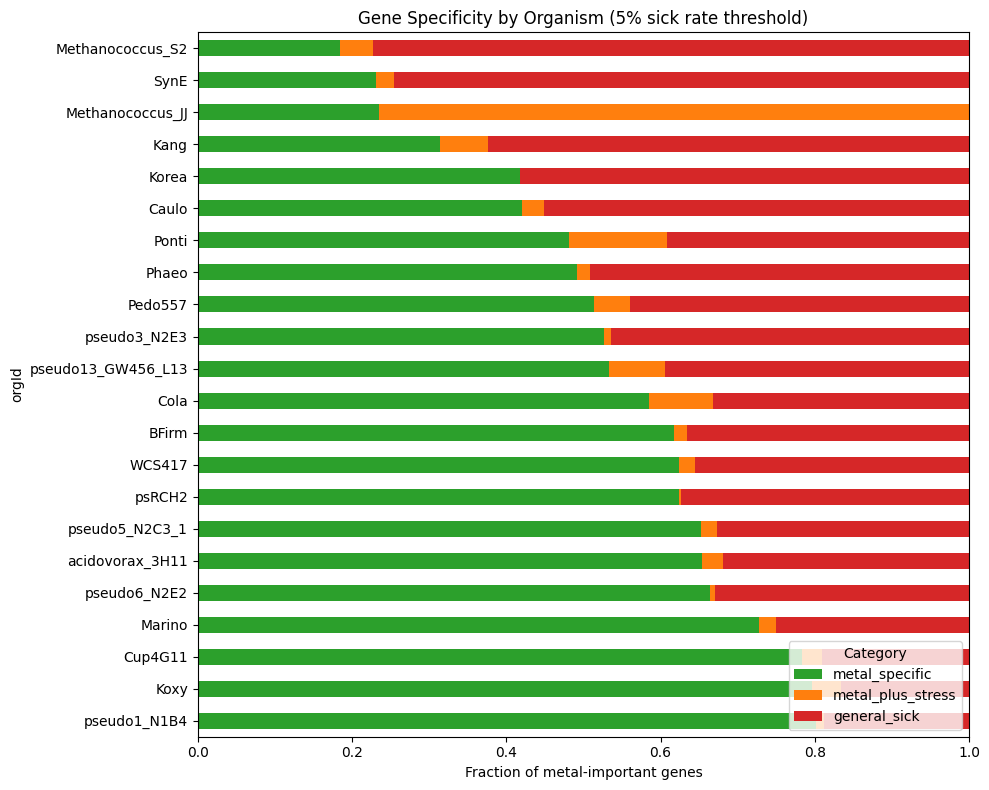

Saved: figures/specificity_breakdown.png


In [9]:
# Visualization: specificity breakdown by organism
fig, ax = plt.subplots(figsize=(10, 8))

plot_cats = ['metal_specific', 'metal_plus_stress', 'general_sick']
plot_colors = ['#2ca02c', '#ff7f0e', '#d62728']
plot_data = org_spec[[c for c in plot_cats if c in org_spec.columns]].copy()
# Normalize to fractions
plot_data_frac = plot_data.div(plot_data.sum(axis=1), axis=0)

plot_data_frac.plot.barh(stacked=True, ax=ax, color=plot_colors[:len(plot_data_frac.columns)])
ax.set_xlabel('Fraction of metal-important genes')
ax.set_title('Gene Specificity by Organism (5% sick rate threshold)')
ax.legend(title='Category', loc='lower right')
ax.set_xlim(0, 1)

plt.tight_layout()
plt.savefig(os.path.join(FIG_OUT, 'specificity_breakdown.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/specificity_breakdown.png')

## Per-metal specificity breakdown

In [10]:
# Join specificity back to metal_genes to get per-metal breakdown
metal_with_spec = metal_genes.merge(
    spec_df[['orgId', 'locusId', 'specificity_5pct', 'sick_rate_nonmetal', 'n_sick_categories']],
    on=['orgId', 'locusId'],
    how='left'
)

# Per-metal summary
metal_spec_summary = metal_with_spec.groupby(['metal_element', 'specificity_5pct']).size().unstack(fill_value=0)
metal_spec_summary['total'] = metal_spec_summary.sum(axis=1)
if 'metal_specific' in metal_spec_summary.columns:
    metal_spec_summary['pct_metal_specific'] = 100 * metal_spec_summary['metal_specific'] / metal_spec_summary['total']
    metal_spec_summary = metal_spec_summary.sort_values('pct_metal_specific', ascending=False)

print('Per-metal specificity breakdown:')
print(metal_spec_summary.to_string())

Per-metal specificity breakdown:
specificity_5pct  general_sick  metal_plus_stress  metal_specific  total  pct_metal_specific
metal_element                                                                               
Chromium                    56                  0              88    144           61.111111
Cadmium                     41                  0              52     93           55.913978
Uranium                     53                  0              65    118           55.084746
Copper                    1073                 77            1283   2433           52.733251
Cobalt                     991                 61            1099   2151           51.092515
Zinc                       772                 33             739   1544           47.862694
Nickel                    1071                101             902   2074           43.490839
Aluminum                   918                 27             718   1663           43.174985
Iron                       197       

In [11]:
# Save full specificity classification
spec_df.to_csv(os.path.join(DATA_OUT, 'gene_specificity_classification.csv'), index=False)
print(f'Saved: data/gene_specificity_classification.csv ({len(spec_df)} records)')

# Save metal-with-specificity join
metal_with_spec.to_csv(os.path.join(DATA_OUT, 'metal_genes_with_specificity.csv'), index=False)
print(f'Saved: data/metal_genes_with_specificity.csv ({len(metal_with_spec)} records)')

# Summary stats
print(f'\n=== Summary ===')
print(f'Total metal-important gene records classified: {len(spec_df)}')
for cat in ['metal_specific', 'metal_plus_stress', 'general_sick']:
    n = (spec_df.specificity_5pct == cat).sum()
    print(f'  {cat}: {n} ({100*n/len(spec_df):.1f}%)')

Saved: data/gene_specificity_classification.csv (6838 records)
Saved: data/metal_genes_with_specificity.csv (12838 records)

=== Summary ===
Total metal-important gene records classified: 6838
  metal_specific: 3691 (54.0%)
  metal_plus_stress: 526 (7.7%)
  general_sick: 2621 (38.3%)
